In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import scipy, os
from sklearn.metrics import confusion_matrix
import seaborn as sns

import sys
sys.path.append('../../Share/')
sys.path.append('../../Share/Manual_processing/')
import baseline, config, Model, utils, Same_with_MATLAB, Feature_info

import warnings
warnings.filterwarnings('ignore')


def restore_labels(mat, labels_windowed):

    original_length = mat['Data_ADC'].shape[1]
    win_size = 600 #Original
    win_step = 120
    valid_length = original_length - 2 * 60

    label_full = np.zeros(original_length, dtype=labels_windowed.dtype) # 복원될 시계열 레이블 (원본 길이)

    # 슬라이딩 윈도우 인덱스 따라 레이블 채워넣기
    for i, label in enumerate(labels_windowed):
        start = 60 + i * win_step
        end = start + win_size
        if end <= original_length - 60:
            label_full[start:end] = label

    return label_full


def filtering_zero(X, y, erase_label):
    # 1. erase_label 제거
    keep_indices = y != erase_label
    X = X[keep_indices]
    y = y[keep_indices]

    # 2. erase_label보다 큰 값은 1씩 감소
    y = np.where(y > erase_label, y - 1, y)

    return X, y

def vis_graph(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.show()

def heatmap_confusion_matrix(X_test, y_test, model):
    # Predict class labels on the test set
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)  # convert softmax probs to predicted class
    y_true = y_test
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(np.max(y_test)+1), yticklabels=range(np.max(y_test)+1))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


from collections import Counter

def balance_data(X, y):
    # Count samples per class
    class_counts = Counter(y)
    min_count = min(class_counts.values())  # target: balance all to minority count

    indices_list = []

    for label in sorted(class_counts.keys()):
        label_indices = np.where(y == label)[0]
        selected_indices = np.random.choice(label_indices, size=min_count, replace=False)
        indices_list.extend(selected_indices)

    # Shuffle all selected indices
    balanced_indices = np.random.permutation(indices_list)

    # Subset the data
    X_balanced = X[balanced_indices]
    y_balanced = y[balanced_indices]

    return X_balanced, y_balanced


In [2]:
fs, lower_cutoff, upper_cutoff = Feature_info.fs, Feature_info.lower_cutoff, Feature_info.upper_cutoff
#filter_b, filter_a = Same_with_MATLAB.cheby2(4, 30, [lower_cutoff / (fs/2), upper_cutoff / (fs/2)], btype='bandpass')

filter_b, filter_a = Same_with_MATLAB.cheby2(4, 30, [lower_cutoff / (fs/2), upper_cutoff / (fs/2)], btype='bandpass')

1. raw data 가지고 직접 processing : Window size + incrmental size / label

In [4]:
path = 'C:/Users/hml76/Documents/MATLAB/data/Exp_2025-07-30/E9AD0E7DCC2B/raw/'
data_per_class_files = os.listdir(path)
X, y = [], []

for cls in data_per_class_files:
    input_path = path+cls+'/'
    files = os.listdir(input_path)
    mat = scipy.io.loadmat(input_path+files[0])
    label = mat['Data_Cls'].reshape(-1)  # shape: (1, 1729)

    feat_mean = np.tile(Feature_info.feat_mean_lst, (4, 1))
    feat_std = np.tile(Feature_info.feat_std_lst, (4, 1))

    mapped_label = np.where(label == 0, 0, int(cls))
    restored_label = restore_labels(mat, mapped_label)

    #print(mat['Data_ADC'].shape, mat['Data_Cls'].shape, restored_label.shape)
    extractor = Same_with_MATLAB.EMGFeatureExtractor(feat_mean, feat_std, filter_b, filter_a, Norm_bool=True, num_feature_set=14)
    extractor.buffer = mat['Data_ADC']
    #1000, 50 = winsize and winstep
    features, labels = extractor.extract_features_with_labels(win_size=1000, win_step=50, feat_exclude=25, filtering=False, restored_label=restored_label) #Same with Ninapro setting

    features = np.transpose(features, (2, 0, 1))  # shape: (1729, 4, 14)
    X.append(features)
    y.append(labels)
    #print(features.shape, labels.shape)
    print(pd.Series(labels).value_counts())

X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)
#X = X[:, :, :, np.newaxis]

print(X.shape, y.shape)

0    3601
1     646
Name: count, dtype: int64
0    3597
2     660
Name: count, dtype: int64
0    3595
3     662
Name: count, dtype: int64
0    3475
4     782
Name: count, dtype: int64
0    3567
5     690
Name: count, dtype: int64
0    3585
6     672
Name: count, dtype: int64
0    3600
7     637
Name: count, dtype: int64
0    3605
8     652
Name: count, dtype: int64
(34026, 4, 14) (34026,)


7    506
8    506
3    506
2    506
6    506
1    506
0    506
4    506
5    506
Name: count, dtype: int64
Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 34.01%
Maximum validation accuracy : 24.2%


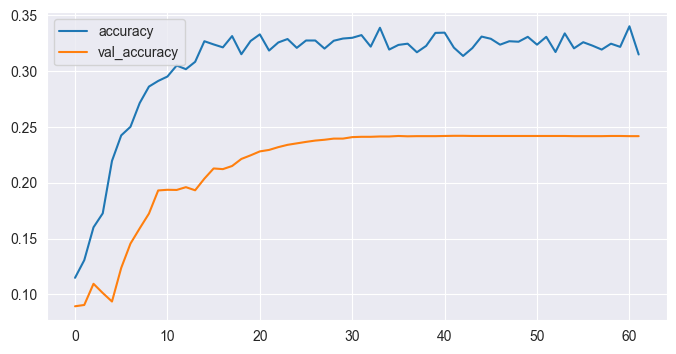

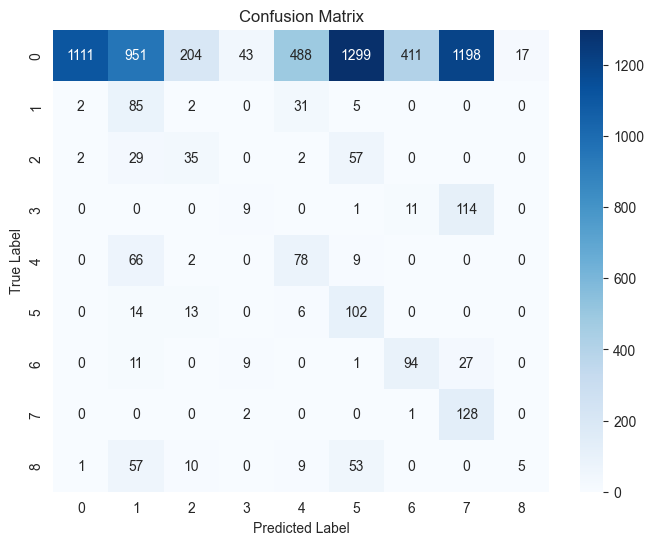

In [11]:
X_train, y_train, X_test, y_test = utils.split_data(X, y, train_ratio=0.8)

# Balance the training set only
X_train_bal, y_train_bal = balance_data(X_train, y_train)
print(pd.Series(y_train_bal).value_counts())

model = Model.Original_model(X_train_bal.shape[1:], num_class=9)

history, model = Model.Train_model(
    model, X_train_bal, y_train_bal, X_test, y_test,
    set_epoch=100, set_batch_size=256, Model_name='V0',
    set_verbose=False, save_model_set=False
)

vis_graph(history)
heatmap_confusion_matrix(X_test, y_test, model)

Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 84.23%
Maximum validation accuracy : 83.73%


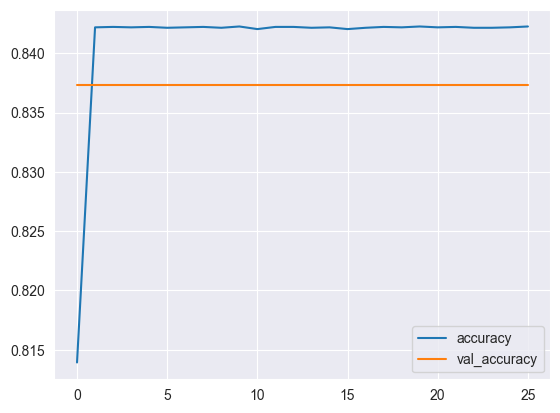

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


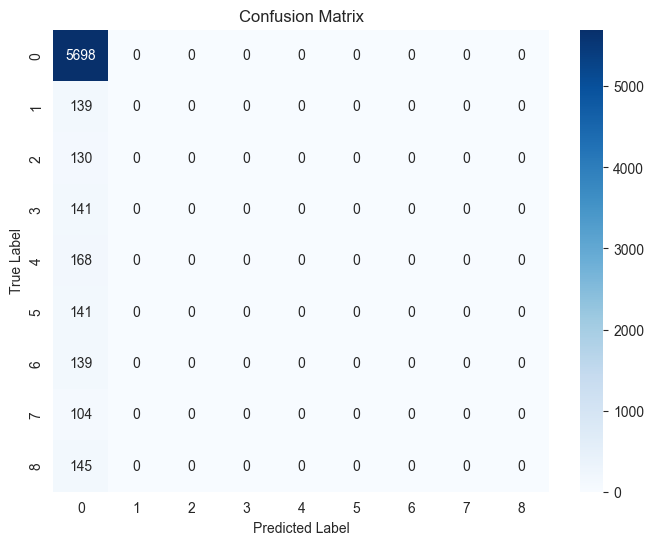

In [27]:
X_train, y_train, X_test, y_test  = utils.split_data(X, y, train_ratio=0.8)

model = Model.Original_model(X_train.shape[1:], num_class=9)

history, model = Model.Train_model(
    model, X_train, y_train, X_test, y_test,
    set_epoch=100, set_batch_size=256, Model_name='V0',
    set_verbose=False, save_model_set=False
)
vis_graph(history)
heatmap_confusion_matrix(X_test, y_test, model)

Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 41.15%
Maximum validation accuracy : 56.45%


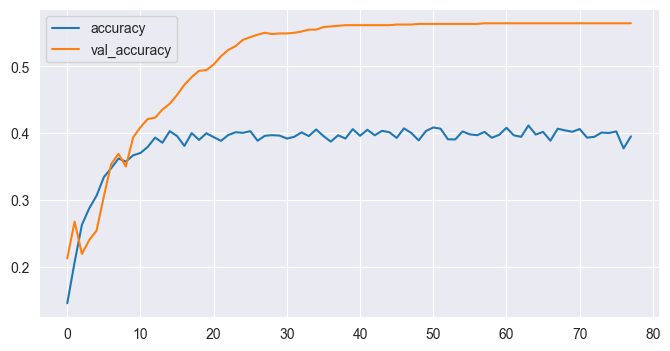

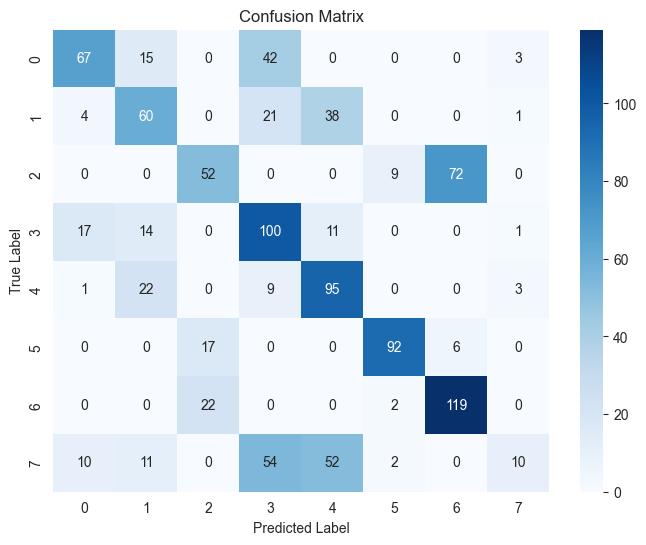

In [12]:
X_train, y_train, X_test, y_test  = utils.split_data(X, y, train_ratio=0.8)
X_train, y_train = filtering_zero(X_train, y_train, erase_label=0)
X_test, y_test = filtering_zero(X_test, y_test, erase_label=0)

model = Model.Original_model(X_train.shape[1:], num_class=np.max(y_train)+1)

history, model = Model.Train_model(
    model, X_train, y_train, X_test, y_test,
    set_epoch=100, set_batch_size=256, Model_name='V0',
    set_verbose=False, save_model_set=False
)
vis_graph(history)
heatmap_confusion_matrix(X_test, y_test, model)

Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 31.88%
Maximum validation accuracy : 42.42%


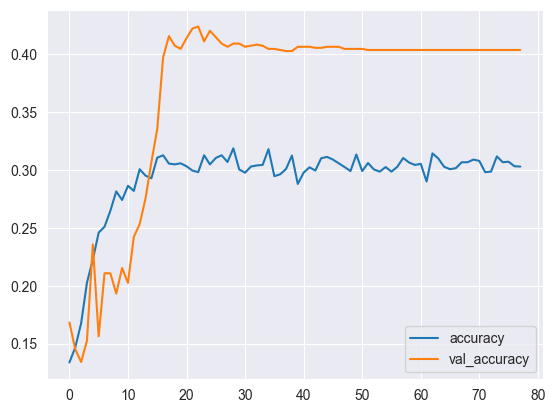

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


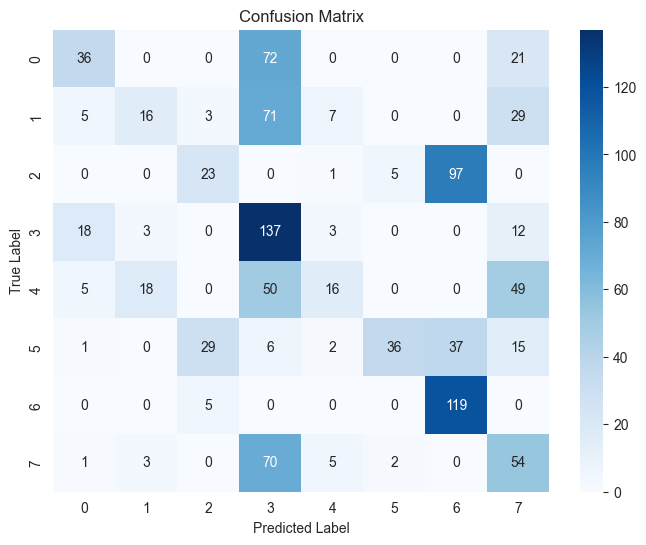

In [29]:
X_train, y_train, X_test, y_test  = utils.split_data(X, y, train_ratio=0.8)
X_train, y_train = filtering_zero(X_train, y_train, erase_label=0)
X_test, y_test = filtering_zero(X_test, y_test, erase_label=0)

model = Model.Original_model(X_train.shape[1:], num_class=np.max(y_train)+1)

history, model = Model.Train_model(
    model, X_train, y_train, X_test, y_test,
    set_epoch=100, set_batch_size=256, Model_name='V0',
    set_verbose=False, save_model_set=False
)
vis_graph(history)
heatmap_confusion_matrix(X_test, y_test, model)

In [30]:
print(pd.Series(y_test).value_counts())

3    173
4    138
7    135
1    131
0    129
5    126
2    126
6    124
Name: count, dtype: int64


In [42]:
import importlib
importlib.reload(Model)

<module 'Model' from 'C:\\Users\\hml76\\PycharmProjects\\MindForce\\github\\Paper\\../Share\\Model.py'>

Start Training (total epochs: 200)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 40.82%
Maximum validation accuracy : 51.81%


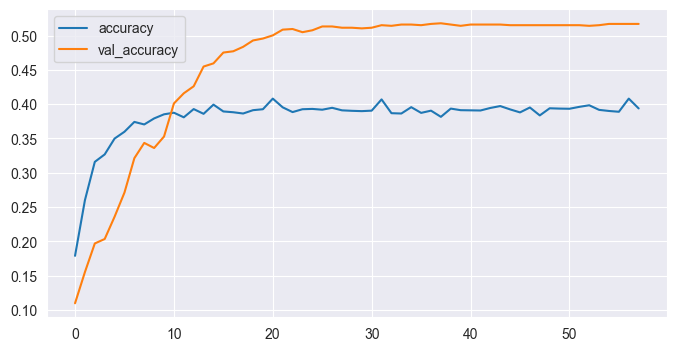

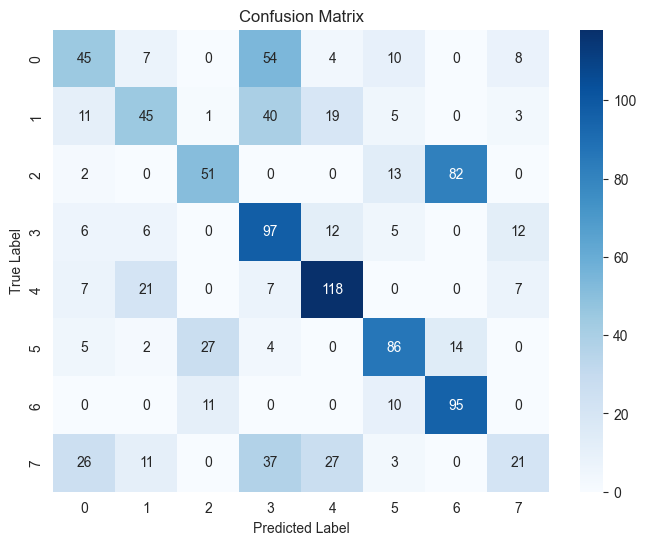

Start Training (total epochs: 200)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 21.07%
Maximum validation accuracy : 18.01%


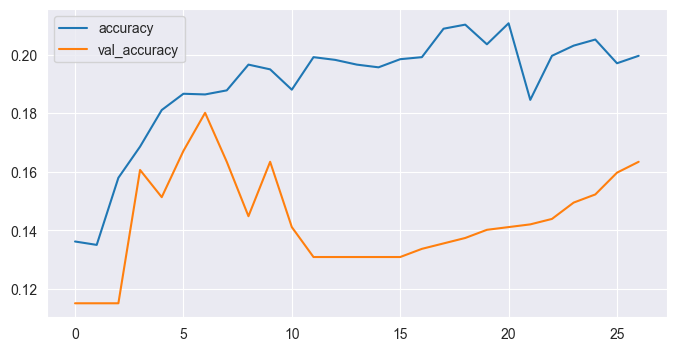

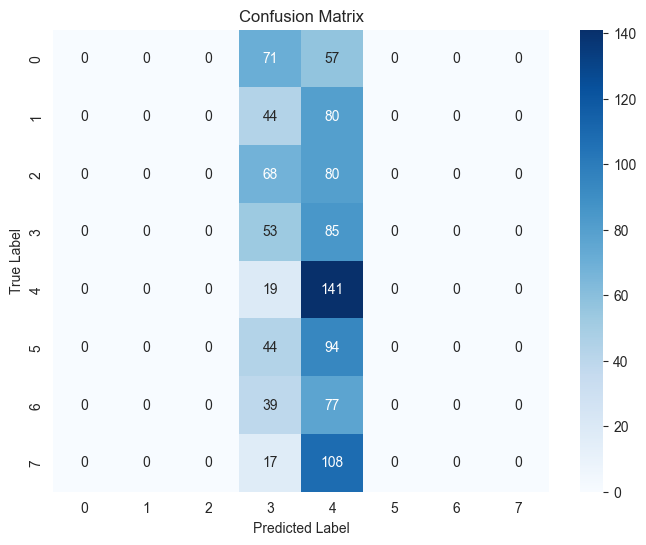

Start Training (total epochs: 200)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 48.17%
Maximum validation accuracy : 66.76%


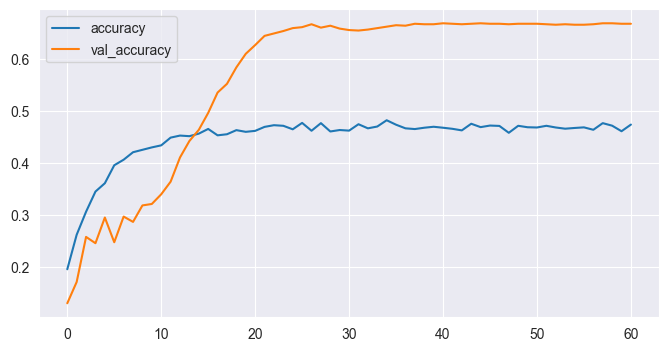

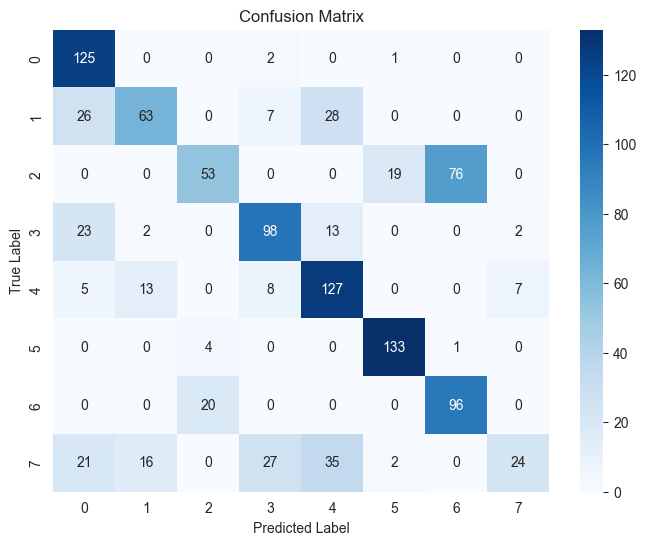

Start Training (total epochs: 200)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 33.86%
Maximum validation accuracy : 44.48%


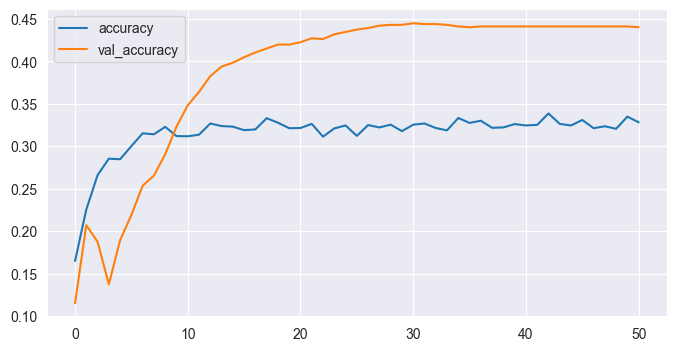

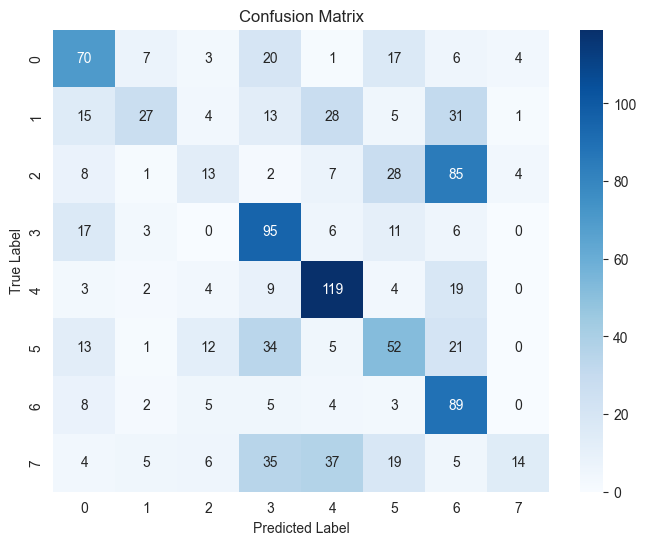

Start Training (total epochs: 200)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 28.98%
Maximum validation accuracy : 33.52%


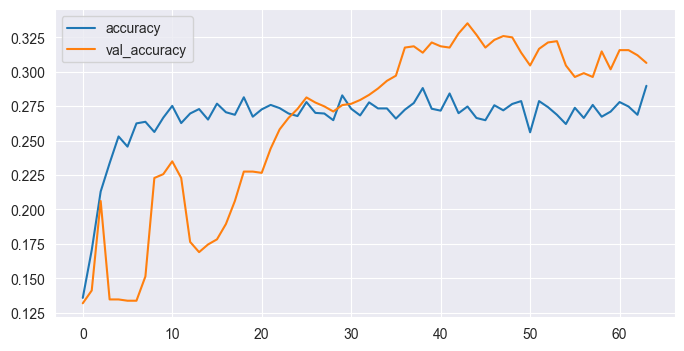

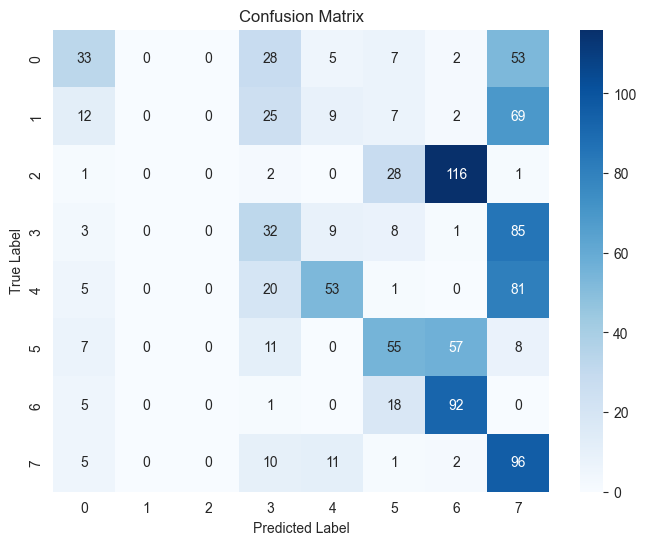

Start Training (total epochs: 200)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 28.08%
Maximum validation accuracy : 28.78%


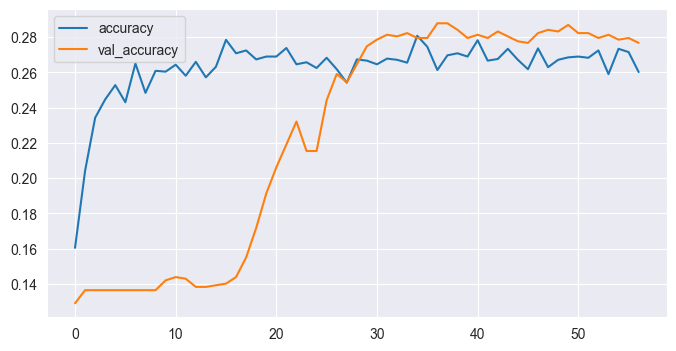

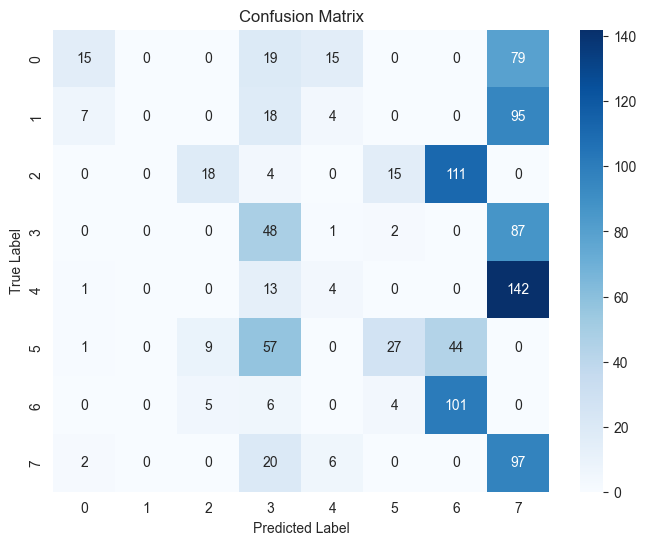

Start Training (total epochs: 200)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 36.17%
Maximum validation accuracy : 50.51%


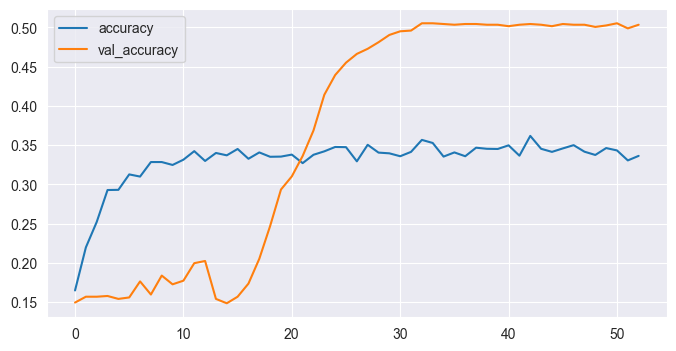

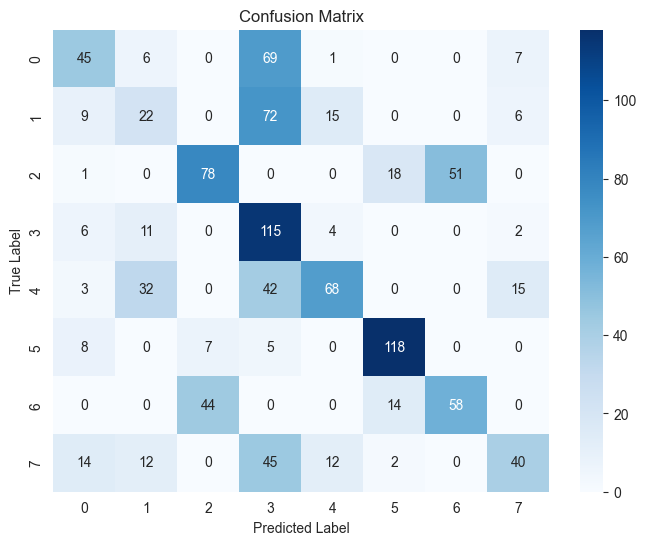

Start Training (total epochs: 200)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 41.98%
Maximum validation accuracy : 54.78%


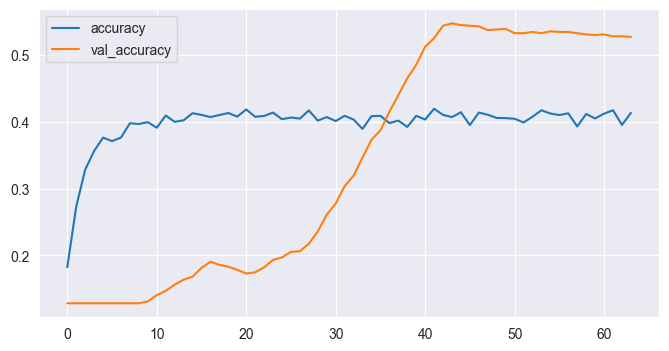

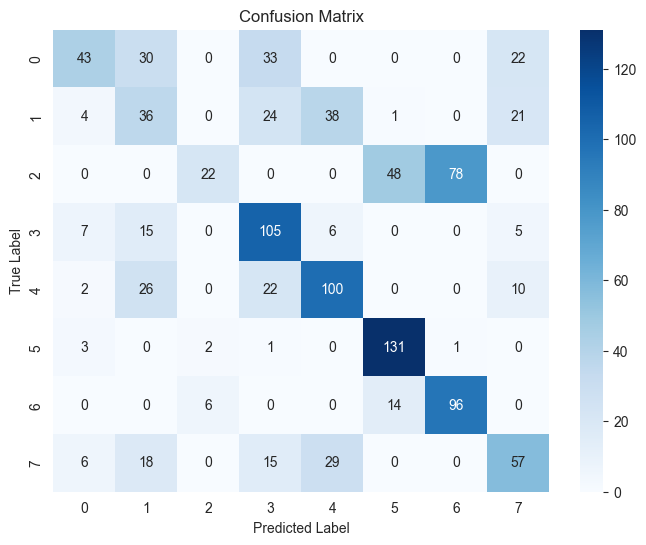

Start Training (total epochs: 200)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 20.58%
Maximum validation accuracy : 24.61%


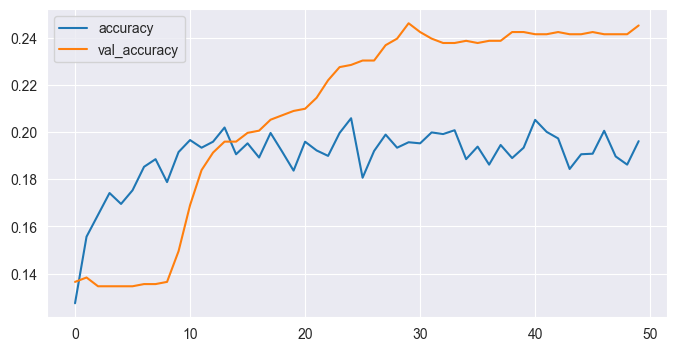

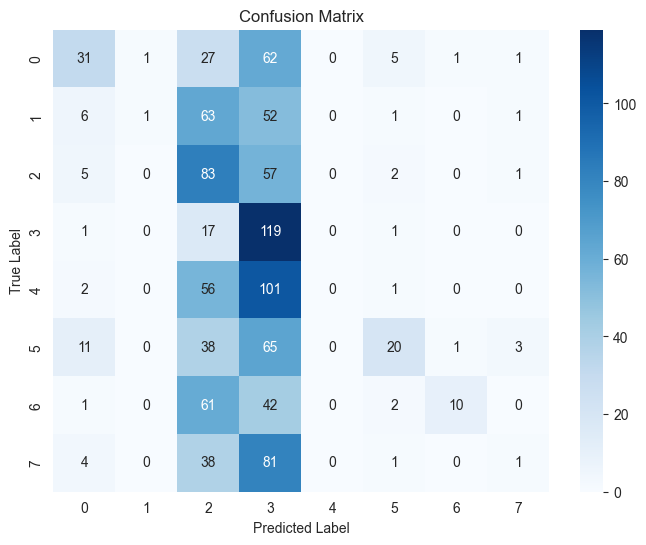

Start Training (total epochs: 200)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 46.23%
Maximum validation accuracy : 61.1%


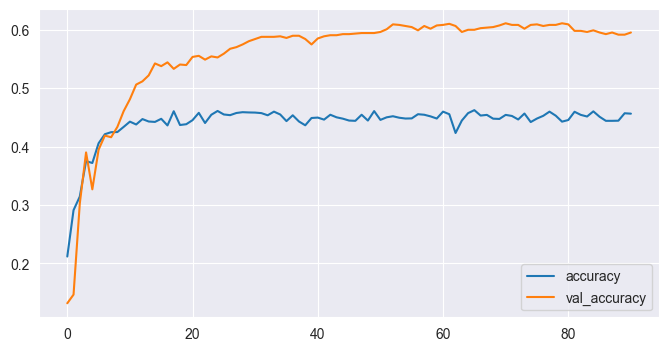

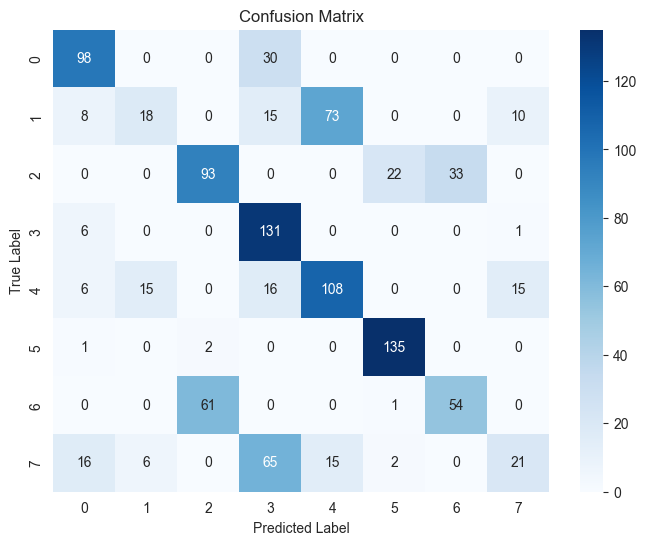

Start Training (total epochs: 200)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 51.13%
Maximum validation accuracy : 67.78%


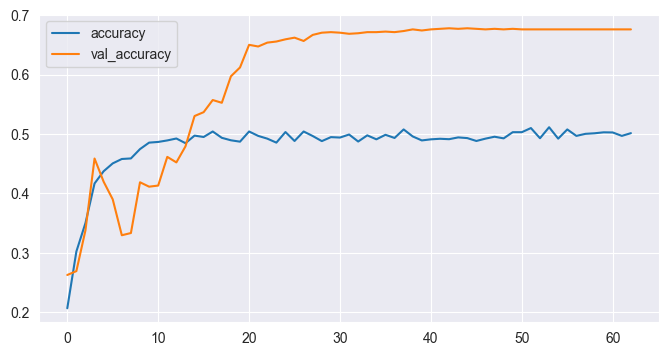

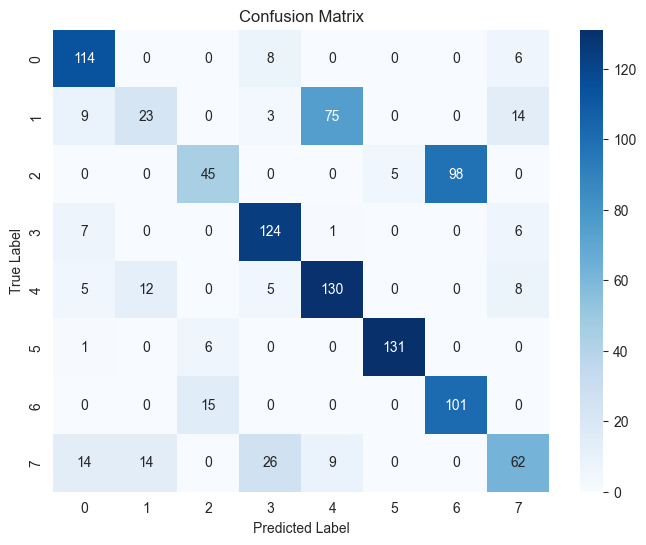

Start Training (total epochs: 200)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 22.53%
Maximum validation accuracy : 31.01%


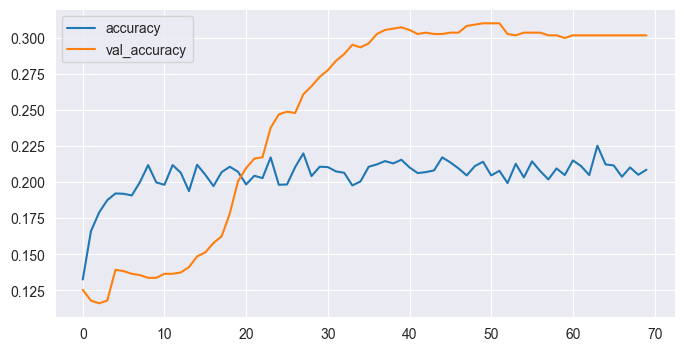

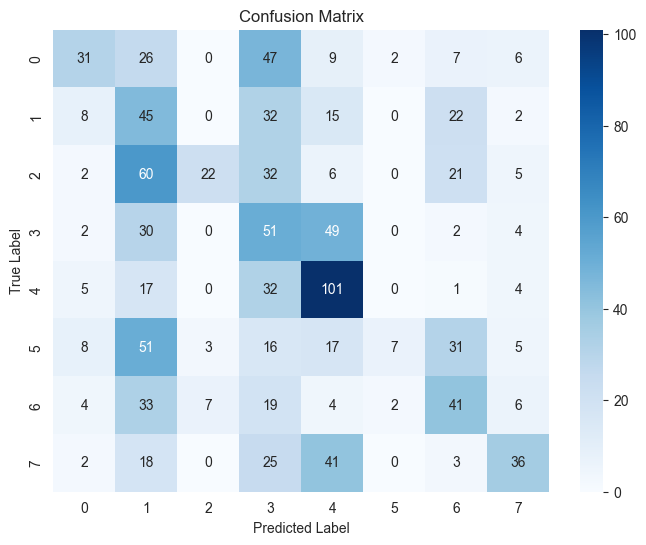

Start Training (total epochs: 200)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 17.41%
Maximum validation accuracy : 17.73%


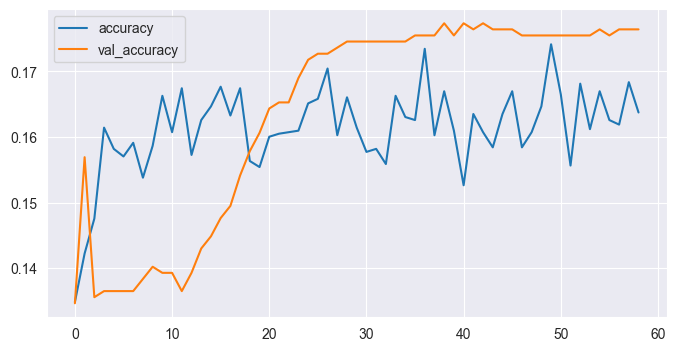

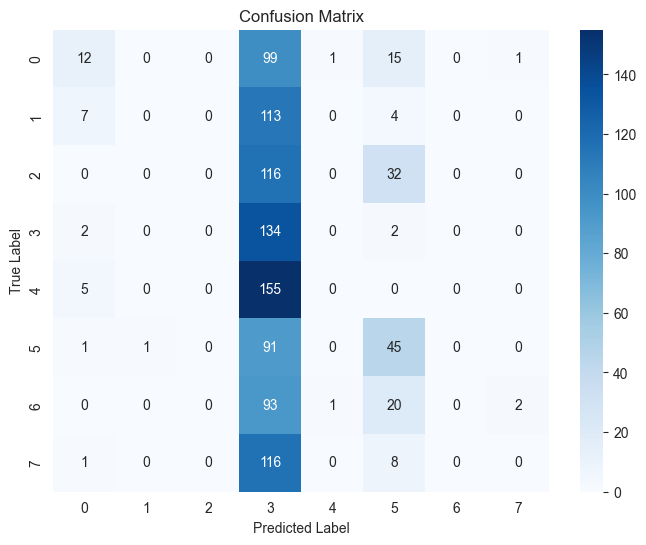

Start Training (total epochs: 200)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 26.2%
Maximum validation accuracy : 30.83%


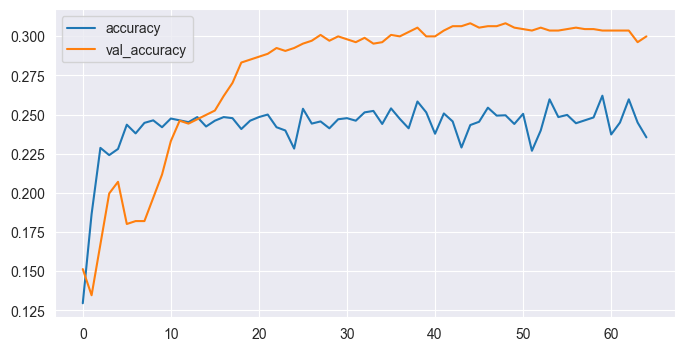

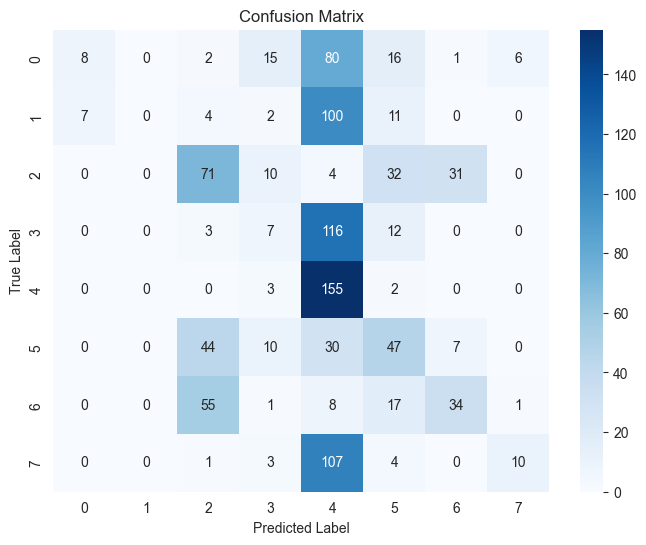

In [8]:
X_train, y_train, X_test, y_test  = utils.split_data(X, y, train_ratio=0.8)
X_train, y_train = filtering_zero(X_train, y_train, erase_label=0)
X_test, y_test = filtering_zero(X_test, y_test, erase_label=0)
ACC_lst = []

for feature_idx in range(X.shape[2]):
    One_X_train = X_train[:, :, feature_idx, :]
    One_X_test = X_test[:, :, feature_idx, :]

    model = Model.Original_model_1DCNN(One_X_train.shape[1:], num_class=np.max(y_train)+1)

    history, model = Model.Train_model(
        model, One_X_train, y_train, One_X_test, y_test,
        set_epoch=200, set_batch_size=256, Model_name='V0',
        set_verbose=False, save_model_set=False
    )
    ACC_lst.append(np.max(history.history['val_accuracy']))
    vis_graph(history)
    #print("\n\n")
    heatmap_confusion_matrix(One_X_test, y_test, model)

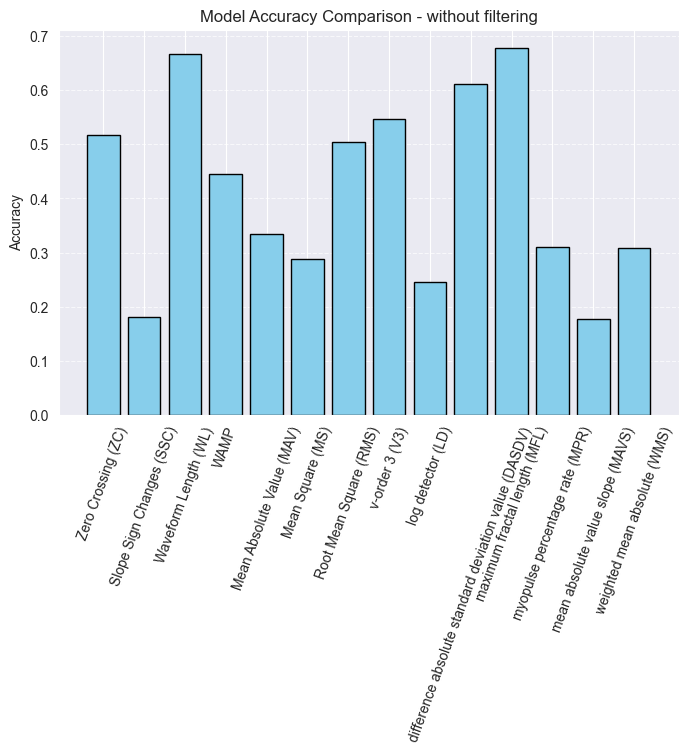

In [10]:
model_names = Feature_info.feature_names #range(14)

plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, ACC_lst, color='skyblue', edgecolor='black')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison - without filtering')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=70)
plt.show()

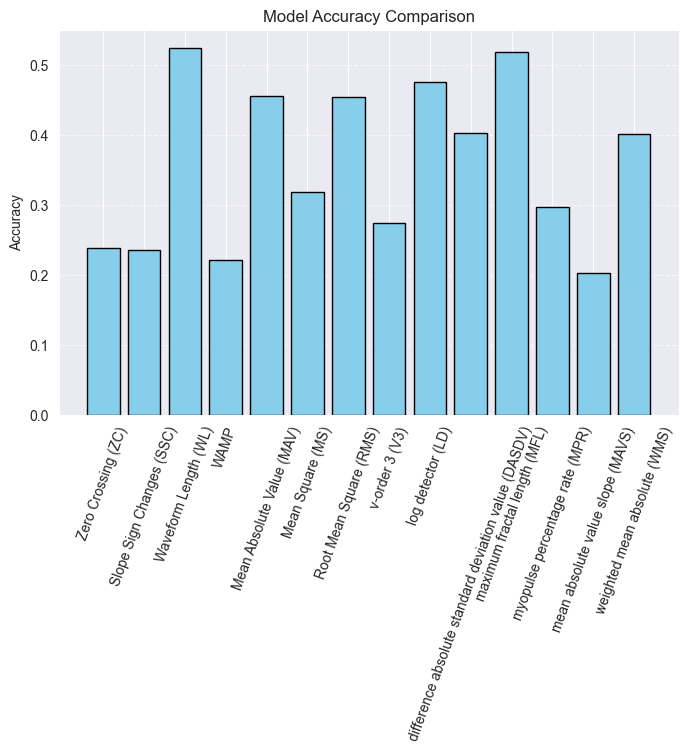

In [59]:
model_names = Feature_info.feature_names #range(14)

plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, ACC_lst, color='skyblue', edgecolor='black')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison - with filtering (original hperparams)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=70)
plt.show()

In [60]:
good_features = [2, 10] #
Feature_info.feature_names[2], Feature_info.feature_names[10]

('Waveform Length (WL)', 'maximum fractal length (MFL)')

In [66]:
X_train, y_train, X_test, y_test  = utils.split_data(X, y, train_ratio=0.8)
X_train, y_train = filtering_zero(X_train, y_train, erase_label=0)
X_test, y_test = filtering_zero(X_test, y_test, erase_label=0)
ACC_lst_LOSO = []

n_sensors = X_train.shape[1]
feature_idx = 2  # or loop if needed

for leave_out_sensor in range(n_sensors):
    train_sensors = [i for i in range(n_sensors) if i != leave_out_sensor] # Prepare training data: exclude the leave-out sensor

    X_train_loso = X_train[:, train_sensors, feature_idx, :]  # shape: (samples, sensors-1, time)
    X_test_loso = X_test[:, leave_out_sensor, feature_idx, :]  # shape: (samples, time)

    X_test_loso = X_test_loso[:, np.newaxis, :] # For 1D CNN, reshape test data to match input shape (samples, 1, time)

    model = Model.Original_model_1DCNN(input_size=X_train_loso.shape[1:],  num_class=np.max(y_train) + 1)
    history, model = Model.Train_model(
        model, X_train_loso, y_train, X_test_loso, y_test,
        set_epoch=200, set_batch_size=256, Model_name=f'LOSO_sensor_{leave_out_sensor}',
        set_verbose=False, save_model_set=False
    )

    acc = np.max(history.history['val_accuracy'])
    ACC_lst_LOSO.append(acc)
    print(f"Sensor {leave_out_sensor} left out → Accuracy: {acc:.2%}\n\n")

ACC_lst_LOSO

Start Training (total epochs: 200)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 27.99%
Maximum validation accuracy : 24.68%
Sensor 0 left out → Accuracy: 24.68%


Start Training (total epochs: 200)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 36.34%
Maximum validation accuracy : 11.5%
Sensor 1 left out → Accuracy: 11.50%


Start Training (total epochs: 200)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 35.09%
Maximum validation accuracy : 12.89%
Sensor 2 left out → Accuracy: 12.89%


Start Training (total epochs: 200)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 33.73%
Maximum validation accuracy : 16.14%
Sensor 3 left out → Accuracy: 16.14%




[np.float64(0.2467532455921173),
 np.float64(0.11502783000469208),
 np.float64(0.12894248962402344),
 np.float64(0.16141001880168915)]

In [63]:
X_train, y_train, X_test, y_test  = utils.split_data(X, y, train_ratio=0.8)
X_train, y_train = filtering_zero(X_train, y_train, erase_label=0)
X_test, y_test = filtering_zero(X_test, y_test, erase_label=0)

for feature_idx in [2]:
    One_X_train = X_train[:, :, feature_idx, :]
    One_X_test = X_test[:, :, feature_idx, :]

    model = Model.Original_model_1DCNN(One_X_train.shape[1:], num_class=np.max(y_train)+1)

    history, model = Model.Train_model(
        model, One_X_train, y_train, One_X_test, y_test,
        set_epoch=200, set_batch_size=256, Model_name='V0',
        set_verbose=False, save_model_set=False
    )

Start Training (total epochs: 200)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 37.53%
Maximum validation accuracy : 50.18%
